In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = [8, 5]

## NPHET IEMAG 2021-06-28 Model Scenario Projections vs Reported Data

This notebook compares the NPHET IEMAG 2021-06-28 model scenario projections with reported data, for 2021-07-01 to 2021-09-30. The projections are the mean values from Table 1 in the [2021-06--28 NPHET letter to the Minister for Health](https://assets.gov.ie/138789/3fe6b992-45e8-4a1c-b4c2-5e4a6131ad53.pdf).

Note:
* The focus is on cases only, as daily data are currently not provided for hospital admissions, ICU admissions, and deaths. These will be included when they are available again.

<img src="figures/20210628_nphet_letter_table1.png" alt="2021-06-28 NPHET Letter - Table 1" width="60%">

### Load the reported case data

In [3]:
casesdf = pd.read_csv('./data/reportedcases.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"))
casesdf.Cases = casesdf.Cases.cumsum()
casesdf['Scenario'] = 'Reported'

### Scenario data 2021-07-01 to 2021-09-30, based on Table 1 above

In [4]:
scenario_dates = pd.date_range('2021-07-01', '2021-09-30')
scenario_cases = [21000, 81000, 187000, 408000, 681000] * len(scenario_dates)
scenarios = ['No Delta', 'Optimistic', 'Central 1', 'Central 2', 'Pessimistic'] * len(scenario_dates)
scenariodf = pd.DataFrame({'Date': np.repeat(scenario_dates, 5), 'Scenario': scenarios, 'Cases': scenario_cases})

### NPHET scenarios vs reported cases

In [5]:
generate_dashes = lambda num_scenarios:[(2,2)] * num_scenarios + ['']
all_scenario_dashes = generate_dashes(5)
optimistic_scenario_dashes = generate_dashes(2)
# Consistent palette for 'No Delta', 'Optimistic', 'Reported'
optimistic_scenario_palette = operator.itemgetter(*[0,1,5])(sns.color_palette())

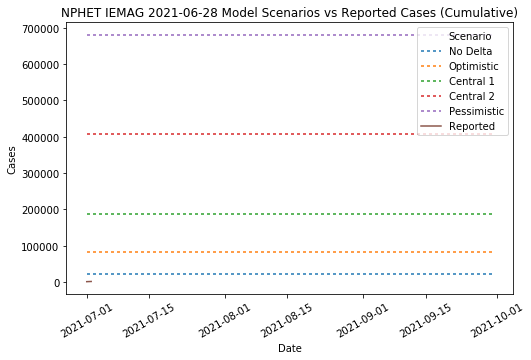

In [6]:
ax = sns.lineplot(data=pd.concat((scenariodf, casesdf), ignore_index=True), x='Date', y='Cases', hue='Scenario', style='Scenario', dashes=all_scenario_dashes)
ax.set_title('NPHET IEMAG 2021-06-28 Model Scenarios vs Reported Cases (Cumulative)')
plt.legend(loc='upper right')
plt.xticks(rotation=30);
plt.savefig('./figures/nphet20210628_all_scenarios_vs_reported_cases.png', bbox_inches="tight")

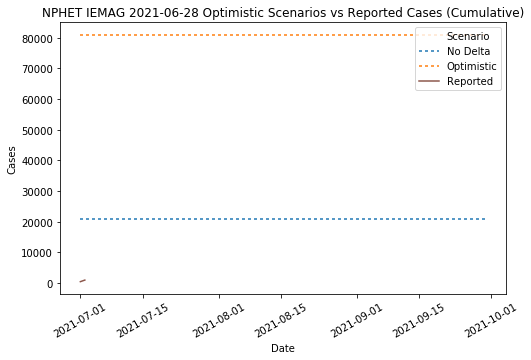

In [7]:
ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(['No Delta', 'Optimistic'])], casesdf), ignore_index=True), x='Date', y='Cases', hue='Scenario', style='Scenario', dashes=optimistic_scenario_dashes, palette=optimistic_scenario_palette)
ax.set_title('NPHET IEMAG 2021-06-28 Optimistic Scenarios vs Reported Cases (Cumulative)')
plt.legend(loc='upper right')
plt.xticks(rotation=30);
plt.savefig('./figures/nphet20210628_optimistic_scenarios_vs_reported_cases.png', bbox_inches="tight")